In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/gsk6me/huggingface_cache'
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [3]:
import argparse
import logging
import math
import os
import random
import shutil
from pathlib import Path

import accelerate
import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import torch.utils.data
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from transformers.utils import ContextManagers

import diffusers
from diffusers import AutoencoderKLTemporalDecoder, DDPMScheduler, StableVideoDiffusionPipeline, UNetSpatioTemporalConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel, compute_snr
from diffusers.image_processor import VaeImageProcessor
from diffusers.utils import check_min_version, deprecate, is_wandb_available, make_image_grid
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.import_utils import is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module

from rt1_dataset_wrapper import RT1Dataset


if is_wandb_available():
    import wandb

/home/gsk6me/miniconda3/envs/py310/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/gsk6me/miniconda3/envs/py310/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-03-12 17:34:25.057311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Pipelines

We have a base pipeline, which is only image-conditioned, and we have a LoRA pipeline, which has had low-rank weight updates made.

In [ ]:
del pipeline_lora
torch.cuda.empty_cache()

In [6]:
# Load the base pipeline
# pipeline_base = StableVideoDiffusionPipeline.from_pretrained(
#     "stabilityai/stable-video-diffusion-img2vid-xt",
#     torch_dtype=torch.float16,
# )
# pipeline_base = pipeline_base.to(device='cuda')
pipename = "stabilityai/stable-video-diffusion-img2vid-xt"
pipeline_lora = StableVideoDiffusionPipeline.from_pretrained(
    pipename,
    torch_dtype=torch.float16,
)
pipeline_lora = pipeline_lora.to(device='cuda')

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

## Inject LoRA

Because the regular pipeline doesn't have an easy way to load LoRA adapters directly, I just manually add them to the U-Net weights. We need to use HuggingFace's SafeTensors library for this.

In [7]:
from peft import LoraConfig

rank = 256
unet_lora_config = LoraConfig(
    r=rank,
    lora_alpha=rank,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)
pipeline_lora.unet.add_adapter(unet_lora_config)

from safetensors import safe_open

# CHECKPOINT = 'snrgamma5-intentional-overfit-100-epochs'
CHECKPOINT = '006_image_pretraining'

tensors = {}
with safe_open(f"./experiments/006_image_pretraining_checkpoints/checkpoint-1000/unet/diffusion_pytorch_model.safetensors", framework="pt", device=0) as f:
# with safe_open(f"./sd-model-finetuned-checkpoints/{CHECKPOINT}/unet/diffusion_pytorch_model.safetensors", framework="pt", device=0) as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)
        # print("Loading tensor", k)

pipeline_lora.unet.load_state_dict(tensors)

<All keys matched successfully>

## Unify with Text Encoder

Here, we create a unified trajectory synthesis pipeline, which is conditioned on text inputs.

In [8]:
from text_and_image_conditioned_video_diffusion_model import VisualTrajectorySynthesizer

# Load the text encoder. This only works for the LoRA model.
text_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
text_encoder = CLIPTextModel.from_pretrained(text_encoder_path).to(device='cuda', dtype=torch.float16)
tokenizer = CLIPTokenizer.from_pretrained(text_encoder_path)

pipeline_lora_unified = VisualTrajectorySynthesizer.from_stable_video_diffusion_pipeline(pipeline_lora, text_encoder)
del pipeline_lora

## Load Data

We only trained on the first $20$ samples from the RT-1 dataset, and of those, we only trained on the first $25$ frames of each video. Let's see how they turned out. We will use the custom class I wrote, `RT1Dataset`, for this. We also need to do a bit of image processing before we can directly send inputs into the model.

In [9]:
from rt1_dataset_wrapper import RT1Dataset

# Originally from `args`
image_height = 256
image_width = 320
vae_image_processor = pipeline_lora_unified.image_processor

# We don't technically even have to do this because the `vae_image_processor` is already called in the StableVideoDiffusionPipeline
def collate_fn(batch):
    # input: (text, image_sequence)[]
    # return: (text batch, text attention masks, text sequence lengths, images)
    text_batch = [text for (text, imgseq) in batch]
    tokenization = tokenizer(text_batch, padding='longest', return_tensors='pt')
    text_tokens = tokenization['input_ids']
    text_attention_masks = tokenization['attention_mask']

    imgseqs = [vae_image_processor.preprocess(imgseq, height=image_height, width=image_width) for (_, imgseq) in batch]

    return (text_tokens, text_attention_masks, torch.stack(imgseqs))

dataset = RT1Dataset('/scratch/gsk6me/WORLDMODELS/datasets/rt-1-data-release')

torch.Size([1, 4, 32, 40])


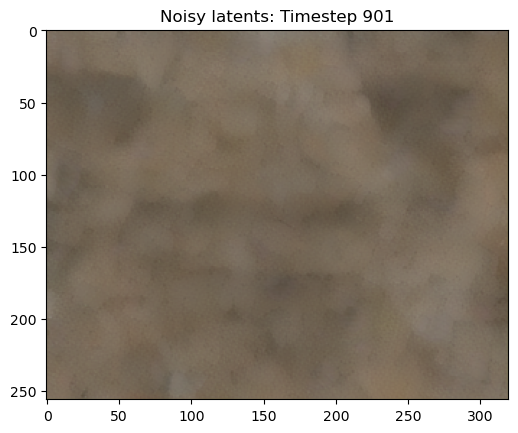

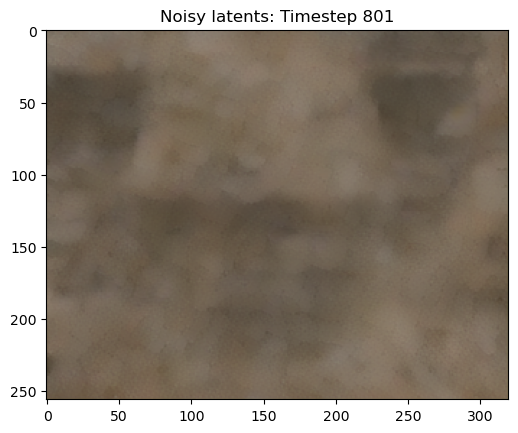

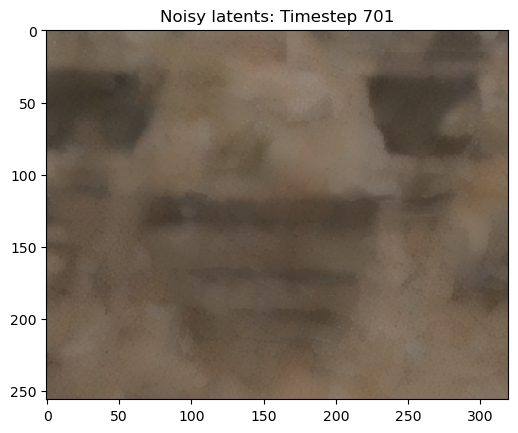

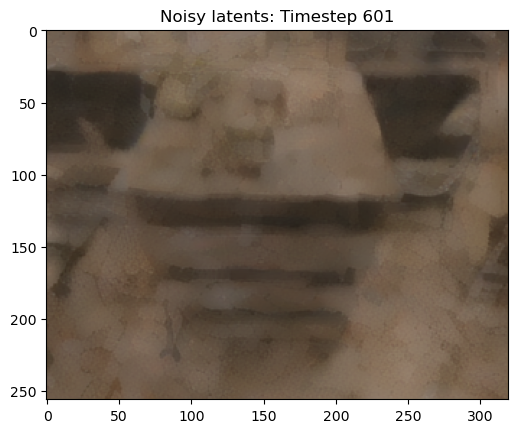

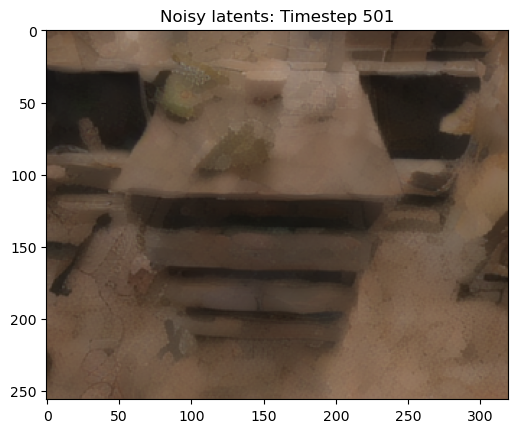

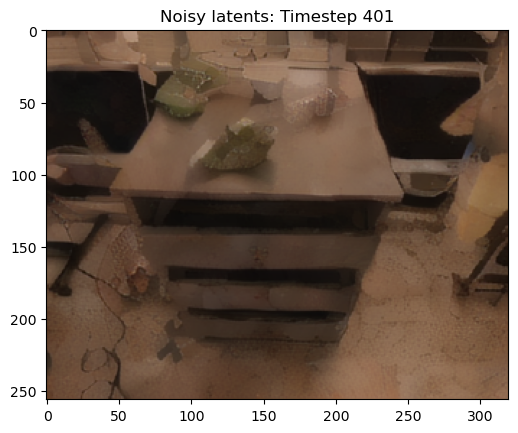

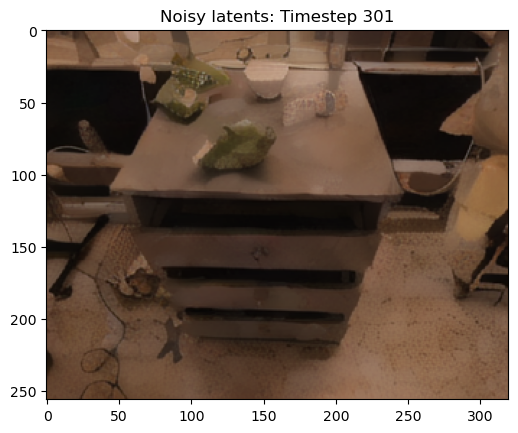

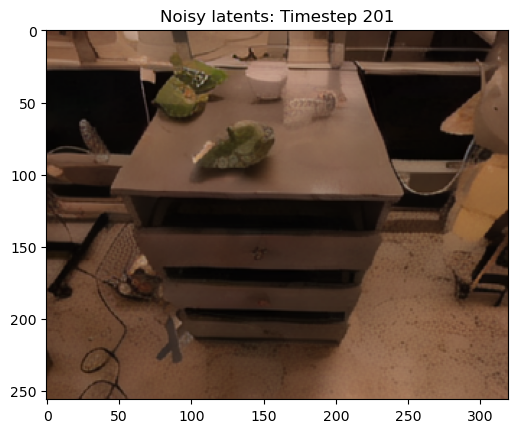

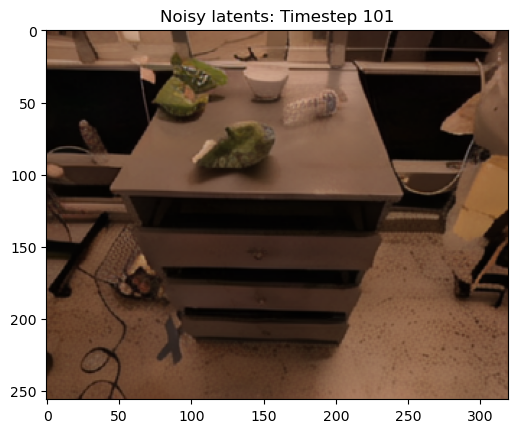

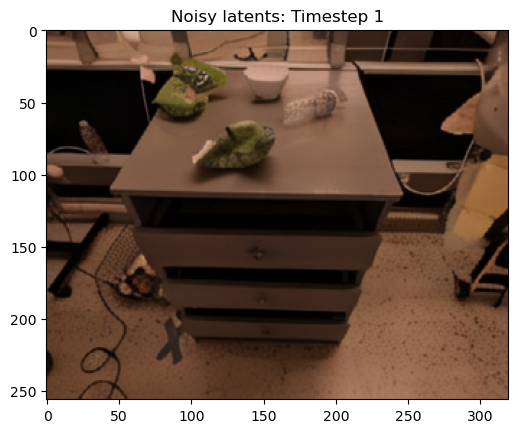

In [14]:
import matplotlib.pyplot as plt

text, image_sequence = dataset[0]

# Encode the image.
image = image_sequence[0]
device = 'cuda'
num_videos_per_prompt = 1
do_classifier_free_guidance = False
pipe = pipeline_lora_unified
num_frames = 8
decode_chunk_size = 8

width = 320
height = 256

scheduler = diffusers.DDPMScheduler.from_pretrained(pipename, subfolder="scheduler")
# scheduler = diffusers.EulerDiscreteScheduler.from_pretrained(pipename, subfolder="scheduler")
scheduler.set_timesteps(10, device='cuda')

with torch.no_grad():
    image = pipe.image_processor.preprocess(image, height=height, width=width).to(device=device, dtype=torch.float16)
    latents = pipe._encode_vae_image(image, device, num_videos_per_prompt, do_classifier_free_guidance)
    print(latents.shape)

    for timestep in scheduler.timesteps:
        noise = torch.randn_like(latents)
    
        noisy_latents = scheduler.add_noise(latents, noise, torch.tensor([timestep]))
        
        reconstructed = pipe.decode_latents(noisy_latents.unsqueeze(0).repeat(8, 1, 1, 1, 1) * pipe.vae.config.scaling_factor, num_frames, decode_chunk_size)
        # print(reconstructed.shape)
        
        batch_vid = reconstructed[0].permute(1, 0, 2, 3)
        batch_output = pipe.image_processor.postprocess(batch_vid.detach(), output_type="pil")
    
        plt.title(f"Noisy latents: Timestep {timestep}")
        plt.imshow(batch_output[0])
        plt.show()


In [16]:
pipe.scheduler.timesteps

tensor([ 1.6378,  1.5755,  1.5110,  1.4440,  1.3743,  1.3018,  1.2260,  1.1469,
         1.0640,  0.9771,  0.8855,  0.7889,  0.6867,  0.5781,  0.4623,  0.3383,
         0.2048,  0.0604, -0.0971, -0.2702, -0.4622, -0.6780, -0.9242, -1.2108,
        -1.5537], device='cuda:0')

In [17]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

image_pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to('cuda')
image_pipe.scheduler.timesteps

/home/gsk6me/miniconda3/envs/py310/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

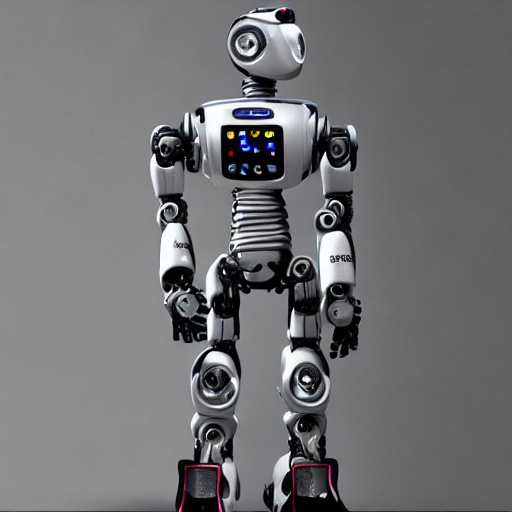

In [20]:
image_pipe("a photo of a robot").images[0]

In [21]:
print(image_pipe.scheduler.timesteps) ### integers?

tensor([981, 961, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741,
        721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461,
        441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181,
        161, 141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')


In [23]:
pipe.scheduler.set_timesteps(1000, device='cuda')
pipe.scheduler.timesteps

tensor([ 1.6378e+00,  1.6363e+00,  1.6348e+00,  1.6334e+00,  1.6319e+00,
         1.6304e+00,  1.6289e+00,  1.6275e+00,  1.6260e+00,  1.6245e+00,
         1.6230e+00,  1.6215e+00,  1.6201e+00,  1.6186e+00,  1.6171e+00,
         1.6156e+00,  1.6141e+00,  1.6126e+00,  1.6111e+00,  1.6096e+00,
         1.6081e+00,  1.6066e+00,  1.6052e+00,  1.6037e+00,  1.6022e+00,
         1.6007e+00,  1.5992e+00,  1.5977e+00,  1.5961e+00,  1.5946e+00,
         1.5931e+00,  1.5916e+00,  1.5901e+00,  1.5886e+00,  1.5871e+00,
         1.5856e+00,  1.5841e+00,  1.5826e+00,  1.5810e+00,  1.5795e+00,
         1.5780e+00,  1.5765e+00,  1.5750e+00,  1.5734e+00,  1.5719e+00,
         1.5704e+00,  1.5689e+00,  1.5673e+00,  1.5658e+00,  1.5643e+00,
         1.5627e+00,  1.5612e+00,  1.5597e+00,  1.5581e+00,  1.5566e+00,
         1.5551e+00,  1.5535e+00,  1.5520e+00,  1.5504e+00,  1.5489e+00,
         1.5473e+00,  1.5458e+00,  1.5442e+00,  1.5427e+00,  1.5411e+00,
         1.5396e+00,  1.5380e+00,  1.5365e+00,  1.5

In [ ]:
# Let's plot what the noised images look like at different timesteps.


In [11]:
from diffusers.utils import export_to_video
import matplotlib.pyplot as plt
import os
import PIL.Image

video_export_dir = f'generated_videos/checkpoints/{CHECKPOINT}'
if not os.path.exists(video_export_dir):
    os.makedirs(video_export_dir)

for n in range(1):
    text, image_sequence = dataset[n]
    input_ids = tokenizer(text, return_tensors='pt').input_ids
    
    # Use the first image as conditioning
    # Note that because training only occurred over the first 25 frames of each video,
    # the model has not seen robots performing task completion yet.
    
    conditioning_image_tensor = image_sequence[0]
    conditioning_image_np = np.array((image_sequence[0] * 255).permute(1, 2, 0)).astype(np.uint8)
    conditioning_image_pil = PIL.Image.fromarray(conditioning_image_np)

    frames = pipeline_lora_unified.custom_call(
        conditioning_image_pil,
        input_ids,
        num_frames=2,
        width=image_width,
        height=image_height,
        was_trained_with_edm_preconditioning=True,
        num_inference_steps=25,
    )

    # Visualize first frame
    plt.imshow(frames[0][0])
    plt.show()
    
    # export_to_video(frames[0], f"{video_export_dir}/generated_lora_{n}_raw.mp4", fps=7)

    # frames = pipeline_base(conditioning_image_pil, width=image_width, height=image_height)
    # export_to_video(frames[0][0], f"generated_non_lora_{n}_raw.mp4", fps=7)

    # os.system(f"ffmpeg -i {video_export_dir}/generated_lora_{n}_raw.mp4 -y {video_export_dir}/generated_lora_{n}.mp4")
    # os.system(f"rm {video_export_dir}/generated_lora_{n}_raw.mp4")
    
    # os.system(f"ffmpeg -i generated_non_lora_{n}_raw.mp4 generated_non_lora_{n}.mp4")
    # os.system(f"rm generated_non_lora_{n}_raw.mp4")

# conditioning_image_pil

Doing classifier-free guidance


  0%|          | 0/25 [00:00<?, ?it/s]

tensor(1.6378, device='cuda:0') 0 25 1000 tensor([ 1.6378,  1.5755,  1.5110,  1.4440,  1.3743,  1.3018,  1.2260,  1.1469,
         1.0640,  0.9771,  0.8855,  0.7889,  0.6867,  0.5781,  0.4623,  0.3383,
         0.2048,  0.0604, -0.0971, -0.2702, -0.4622, -0.6780, -0.9242, -1.2108,
        -1.5537], device='cuda:0')


IndexError: tensors used as indices must be long, int, byte or bool tensors

In [11]:
from diffusers import AutoencoderKLTemporalDecoder
vae = AutoencoderKLTemporalDecoder.from_pretrained( # type: ignore
    pipename, subfolder="vae"
)
vae = vae.to('cuda')

In [12]:
text, images = dataset[0]
preprocessed_images = pipeline_lora_unified.image_processor.preprocess(images, width=320, height=256)

In [39]:
import numpy as np
import os
import subprocess
from IPython.display import Video, display
import cv2

def render_video(tensor_sequence, index):
    # Convert the PyTorch tensors to numpy arrays
    frames = [(tensor.permute(1, 2, 0).cpu().numpy()[:, :, ::-1] * 255).astype(np.uint8) for tensor in tensor_sequence]

    # Define the video writer
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('_generated.mp4', fourcc, 30.0, (width, height))

    # Write each frame to the video
    for frame in frames:
        out.write(frame.astype(np.uint8))

    # Release the video writer
    out.release()

    with open(os.devnull, 'wb') as devnull:
        subprocess.check_call(['ffmpeg', '-y', '-i', '_generated.mp4', f'generated_{index}.mp4'], stdout=devnull, stderr=devnull)

    os.system('rm _generated.mp4')
    
    return Video(f'generated_{index}.mp4')

In [40]:
vae = pipeline_lora_unified.vae
dtype = torch.float16

for index in [18, 180, 1800, 18000]:
    text_description, video = dataset[index]

    video = video[:1]
    
    print("Original Video")
    display(render_video(video, 'original_' + str(index)))
    
    # Now, let's see what it looks like if we pass it in and out of the VAE.
    with torch.no_grad():
        latents = []
        for image in video:
            encoded = vae.encode(
                pipeline_lora_unified.image_processor.preprocess(
                    image.to(device='cuda', dtype=dtype),
                    height=256, width=320,
                )
            )
            latents.append(
                encoded.latent_dist.sample()[0] # * vae.config['scaling_factor']
            )
        latents = torch.stack(latents)
        
        # Decode latents in chunks of 8
    
        returned = []
        i = 0
        while i < len(latents):
            frames = latents[i:i + 8]
            returned.append(vae.decode(frames, num_frames=len(frames)).sample)
            i += 8
    
        returned = (1 + torch.cat(returned)) / 2
        returned = torch.clamp(returned, 0, 1)
    
    print("Autoencoder Video")
    display(render_video(returned, 'autoencoder_' + str(index)))

Original Video


Autoencoder Video


Original Video


Autoencoder Video


Original Video


Autoencoder Video


Original Video


Autoencoder Video


In [17]:
frames[0].shape

torch.Size([16, 3, 256, 320])

In [23]:
for n in range(20):
    print(n, dataset[n][0])

0 open bottom drawer
1 pick rxbar blueberry
2 move water bottle near blue plastic bottle
3 pick brown chip bag from top drawer and place on counter
4 pick banana from white bowl
5 open bottom drawer
6 close bottom drawer
7 move rxbar blueberry near blue chip bag
8 place coke can into middle drawer
9 open middle drawer
10 open bottom drawer
11 pick coke can from bottom drawer and place on counter
12 move water bottle near 7up can
13 pick 7up can from top drawer and place on counter
14 pick 7up can
15 close middle drawer
16 move rxbar chocolate near apple
17 place blue plastic bottle into bottom drawer
18 open top drawer
19 close bottom drawer
